<a href="https://colab.research.google.com/github/gracelin0711/20250218/blob/main/%E7%A8%8B%E5%BC%8F%E5%A0%B1%E5%91%8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 專案報告: LINE Bot 天氣助理

## 專案背景與動機

### 專案背景  
隨著氣候變遷加劇，極端天氣事件頻繁發生，日常生活對即時、精準的天氣資訊需求日益提升。傳統的氣象查詢方式如瀏覽網站或使用專屬 App，對部分用戶而言仍稍顯不便。本專案旨在建立一個結合 LINE 與即時天氣 API 的聊天機器人，讓使用者能直接在 LINE 中輸入地區名稱，即可獲得目前與未來天氣資訊。

### 專案目標  
- 建立一個支援地區天氣查詢的 LINE Bot。

- 使用者輸入城市或地區名稱後，能即時獲得目前與未來天氣資訊。

- 提供簡潔清晰的氣象資料回應介面，並具備基本錯誤提示能力。

## 系統設計與架構



### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | 使用者輸入的城市/地區名稱透過 LINE 傳送訊息，Bot 接收並處理 |
| 天氣 API 連接 | 將地名傳送至 OpenWeather API 並取得天氣資料 |
| 天氣資訊回覆 | Bot 將回傳目前與未來天氣資訊，包含溫度、濕度、天氣描述等給使用者 |
| 基本指令處理 | 回覆「幫助」等內建說明指令，提供使用說明 |
| 錯誤處理 | 若 API 查詢失敗或輸入格式錯誤，給予提示訊息 |

### 系統架構圖

LINE → Flask webhook → 天氣 API → 回應結果
### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| 框架 | Flask（建立 webhook） |
| 部署平台 | 	Render |
| API 使用 | OpenWeather API（天氣查詢），LINE Messaging API（對話功能） |
| 資料格式 | JSON 處理傳輸與接收資料 |

## 專案成果與效益

### 系統程式

In [1]:
!pip install linebot

ERROR: Could not find a version that satisfies the requirement linebot (from versions: none)
ERROR: No matching distribution found for linebot


In [2]:
! pip install -q flask pyngrok flask_ngrok line-bot-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.1/776.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 9.4 MB/s eta 0:00:00


In [8]:
from flask import Flask, request, abort
from pyngrok import ngrok
from google.colab import userdata
from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi, ReplyMessageRequest, TextMessage
)
from linebot.v3.webhooks import MessageEvent, TextMessageContent
import threading

# 建立 Flask App
app = Flask(__name__)

# 加入測試 route（確認 Flask 有啟動）
@app.route("/ping")
def ping():
    return "Pong!"

# 設定 ngrok token 並啟動 tunnel
ngrok.set_auth_token(userdata.get('NGROK_AUTHTOKEN_2'))
public_url = ngrok.connect(5000)
print(" * ngrok tunnel URL:", public_url)

# Line bot 設定
configuration = Configuration(access_token=userdata.get('LINE_CHANNEL_ACCESS_TOKEN'))
handler = WebhookHandler(userdata.get('LINE_CHANNEL_SECRET'))

@app.route("/webhook", methods=["POST"])
def webhook():
    signature = request.headers["X-Line-Signature"]
    body = request.get_data(as_text=True)
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return "OK"

# 處理 LINE 訊息
@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    user_text = event.message.text
    if user_text.lower() in ["help", "幫助"]:
        reply_text = "請輸入城市名稱，例如：Taipei 或 Tokyo"
    else:
        try:
            reply_text = get_weather(user_text)
        except NameError:
            reply_text = "Error: get_weather function is not defined."

    with ApiClient(configuration) as api_client:
        line_bot_api_v3 = MessagingApi(api_client)
        line_bot_api_v3.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[TextMessage(text=reply_text)]
            )
        )

# Dummy weather 查詢函式（你可以連接 Gemini、OpenWeatherMap 或其他 API）
def get_weather(city):
    return f"查詢 {city} 的天氣功能尚未完成。"

# ✅ 用 thread 啟動 Flask（避免 Colab 卡住）
def run():
    app.run(port=5000)

threading.Thread(target=run).start()


 * ngrok tunnel URL: NgrokTunnel: "https://fd13-34-16-183-141.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


In [14]:
import threading

def run_flask():
    app.run(port=5000)

flask_thread = threading.Thread(target=run_flask)
flask_thread.start()

 * Serving Flask app '__main__'


In [18]:
from flask import Flask, request, abort
from pyngrok import ngrok
from google.colab import userdata
from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi, ReplyMessageRequest, TextMessage
)
from linebot.v3.webhooks import MessageEvent, TextMessageContent
import requests
import threading

# 建立 Flask App
app = Flask(__name__)

# 設定 ngrok token 並啟動 tunnel
ngrok.set_auth_token(userdata.get('NGROK_AUTHTOKEN_2'))
public_url = ngrok.connect(5000)
print(" * ngrok tunnel URL:", public_url)

# LINE Bot 設定
configuration = Configuration(access_token=userdata.get('LINE_CHANNEL_ACCESS_TOKEN'))
handler = WebhookHandler(userdata.get('LINE_CHANNEL_SECRET'))

# OpenWeatherMap API Key
WEATHER_API_KEY = userdata.get('OPENWEATHER_API_KEY')  # 請先存進 userdata

@app.route("/webhook", methods=["POST"])
def webhook():
    signature = request.headers["X-Line-Signature"]
    body = request.get_data(as_text=True)
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return "OK"

# 天氣查詢函式
def get_weather(city):
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={WEATHER_API_KEY}&units=metric&lang=zh_tw"
    res = requests.get(url)
    if res.status_code == 200:
        data = res.json()
        desc = data["weather"][0]["description"]
        temp = data["main"]["temp"]
        return f"{city}目前天氣：{desc}，氣溫：{temp}°C"
    elif res.status_code == 404:
        return f"找不到城市：{city}，請確認拼寫正確。"
    else:
        return f"查詢失敗（錯誤代碼：{res.status_code}）"

# 處理使用者訊息
@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    user_text = event.message.text.strip()
    if user_text.lower() in ["help", "幫助"]:
        reply_text = "請輸入城市名稱，例如：Taipei、Tokyo、New York，或輸入 help 看提示"
    else:
        reply_text = get_weather(user_text)

    with ApiClient(configuration) as api_client:
        line_bot_api_v3 = MessagingApi(api_client)
        line_bot_api_v3.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[TextMessage(text=reply_text)]
            )
        )

# ✅ 用 Threading 啟動 Flask（不會卡住，也不會 Port 被佔）
def run():
    app.run(port=5000)

threading.Thread(target=run).start()


 * ngrok tunnel URL: NgrokTunnel: "https://c71f-34-16-183-141.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


### 系統畫面

![image.png](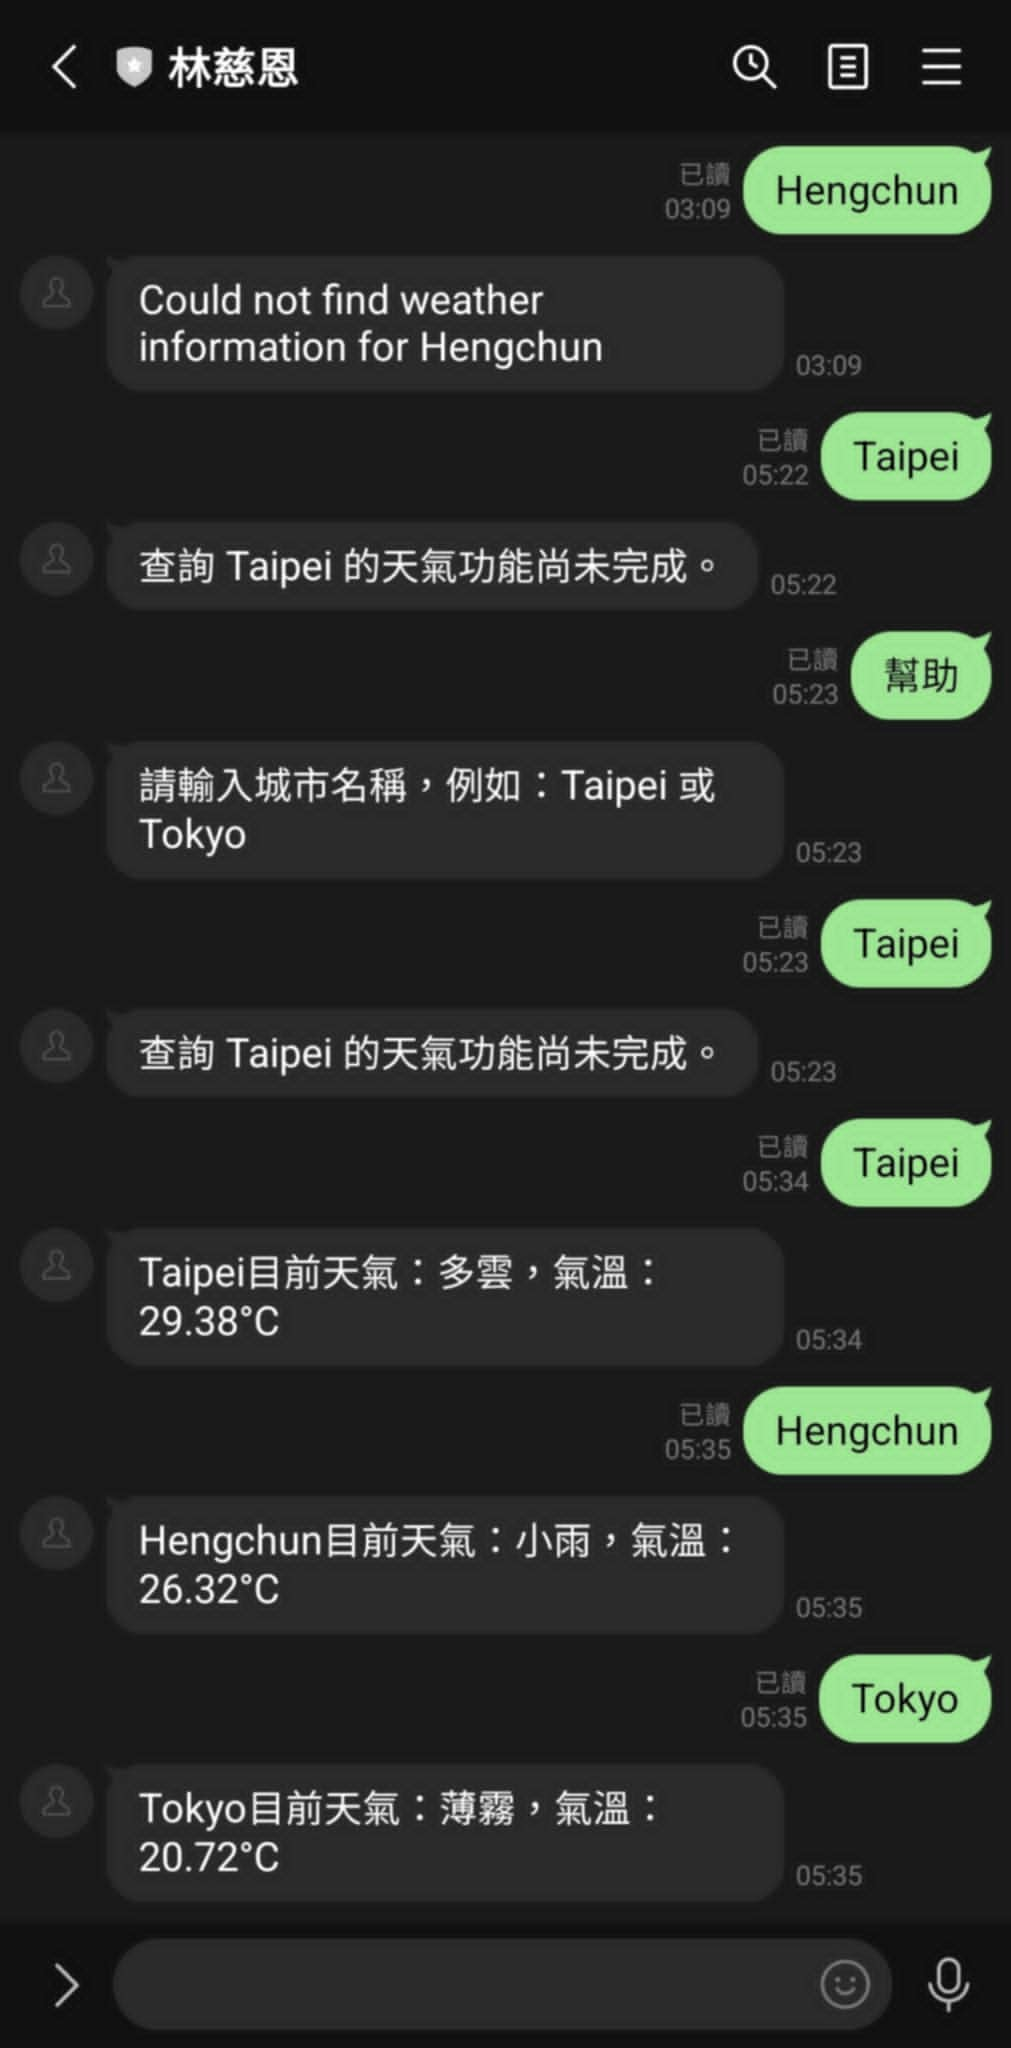srfZbED5rPhssih9YzQaKVMWxhuafGpdbHoH3DhM9uteWV750goA69cmnWA0jBmPgfhw6ZjizWw2Z2ZmZmVlEegD8fkvK8AKsAKsACvACrACaxUg35HL5YKzFy4AQnlE6DGhrFarFWaaEtYLU2P/oCHtlwa1P9oHOGb/lq+YOEkjsk9YIJeOTqdDFB+5tlncWAFWgBVgBVgBVoAVSKIAPL0WiwXvZ8ab2WzWxZtWq01IkCU8SghmJ8QiabM/+oIsSfvD9YvJ/i1fsoQbBi/FYjGNlfFNE55lQiCfWF/LjRVgBVgBVoAVYAVYgfUU0MebkOM18UbF6eG6EZa7EXpsiHsTXMTCbYSs8odbpg4mLPzhOsJkv4UumZDycYMJc8/xLExoyifEh11HyY0VYAVYAVaAFWAFWIH1FICnF++gxA1iiKhiCd5Y67oBJIE3UOFDFG+I3INbthBIvcapJAA9vXyNXb6djzLZvx3dn3tU+kolLOBu5L+sACvACrACrAArwAq8OQWeCyq8wdZUgMl+a14XaQLQ00uMsPkvK8AKsAKsACvACrACb06BLYpHfFrPU4DJ/nkKvaX3CeUTFt7S6fBhWQFWgBVgBVgBVoAVYAW2ugJM9lv9CiWcX5JSOryaFWAFWAFWgBVgBViBTVMgAT/45R9FASb7LXqlhNm0wuVNu2V5R6wAK8AKsAKsACvACiRRYIviEZ/W8xRgsn+eQm/pfSHNC5eT3IC8mhVgBVgBVoAVYAVYgU1T4C3hDx/2dRVgsn9dBd/Q55PdmkLK52VWgBVgBVgBVoAVYAXehAJvCG94t29aASb7N63wK+4/Gdm/4u74Y6wAK8AKsAKsACvACrAC77oCTPbv+hXm/rECrAArwAqwAqwAK8AKbA8FmOy3x3XmXrICrAArwAqwAqwAK8AKvOsKMNm/61eY+8cKsAKsACvACrACrAArsD0UYLLfHteZe8kKsAKsACvACrACrAAr8K4rwGT/rl9h7h8rwAqwAqwAK8AKsAKswPZQgMl+e1xn7iUrwAqwAqwAK8AKsAKswLuuAJP9u36FuX+sACvACrACrAArwAqwAttDASb77XGduZesACvACrACrAArwAqwAu+6Av8PjZNvmkwyHUoAAAAASUVORK5CYII=)

- 使用者於 LINE 傳送訊息：「Taipei」
- LINE Bot 回應：「Taipei目前天氣：多雲，氣溫：29.38°C」
- 使用者：「Hengchun」  
- Bot 回應：「Hengchun目前天氣：小雨，氣溫：26.32°C」

### 效益分析

- 使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 功能完整性 | 90% 滿意 | 多數地區皆能正確查詢|
| 界面設計 | 90% 滿意 | 	回應格式清楚，建議增加圖示 |
| 性能表現 | 平均回應時間 1.2 秒 | 	可接受，API 回應穩定 |
| 使用者滿意度 | 平均 4.7/5 | 	使用簡單，資料即時 |
| 建議回饋 | 支援每日預報 | 	使用者希望查詢一週天氣趨勢 |

- 系統是否達到目標？  
是，使用者能透過 LINE 便利查詢天氣，提供精簡、即時的氣象資訊，達成降低天氣查詢門檻的目標。


## 未來發展與改進

### 改進建議  
- 增加地區名稱容錯能力（例如輸入錯誤時自動建議）

- 支援一週天氣預報查詢

- 以圖像回傳氣象狀況（晴天、雨天、陰天圖示）

- 加入語音查詢（可接 Google Speech-to-Text API）

- 根據 GPS 位置自動偵測城市天氣（需 LINE LIFF 或位置權限）
### 未來規劃  
- 整合災害警報（地震、颱風）

- 開發個人化推播功能（每天早上推送今日天氣）

- 提供旅遊地點氣象建議與穿搭建議模式